# Training notebook for training and evaluating the Dev-ResNet model 

A notebook outlining the training and evaluation procedure for Dev-ResNet. Note that this is specifically for a dataset comprising developmental sequences of the great pond snail, Lymnaea stagnalis.

## Dependencies

The following are required dependencies for this script. We also set up mixed precision training for the speedup it provides in training time.

In [1]:
import glob
import vuba
import cv2
import numpy as np
import re
from tensorflow import keras
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm
from typing import Tuple
import atexit
import time
import os
import ujson
import math
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

from resnet3d_temporal import model as resnet3dT

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# Parameters ----------------------------------------------------------
batch_size = 32
input_shape = (12, 128, 128, 1)
epochs = 50
model_save_dir = './trained_models'
events = ['blastula', 'gastrula', 'trocophore', 'veliger', 'eye', 'heart', 'crawling', 'radula', 'hatch', 'dead']
# ---------------------------------------------------------------------

2023-07-13 14:16:30.943500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 14:16:31.022469: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 14:16:31.448938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/ho

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090 Laptop GPU, compute capability 8.9


2023-07-13 14:16:35.898460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 14:16:35.911415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 14:16:35.911567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 14:16:35.911815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dataset pipeline

The following dataset pipeline is using an augmented dataset generated from manually annotated developmental sequences. Note that images are rescaled by default in the model so images can be supplied in uint8 format.

In [ ]:
def read_data(fn, label):
    gif = tf.io.read_file(fn)
    gif = tf.image.decode_gif(gif)
    gif = tf.image.resize_with_pad(gif, 128, 128)
    gif = tf.image.rgb_to_grayscale(gif)
    return gif, label

def dataset(images, labels, batch_size): 
    data = tf.data.Dataset.from_tensor_slices((images, labels))
    data = data.map(read_data, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(batch_size, drop_remainder=True)
    return data

annotations_train = pd.read_csv('./annotations_original_new_gif_train_aug.csv')
annotations_train = annotations_train.sample(frac=1).reset_index(drop=True)
annotations_train['categorical'] = [events.index(e) for e in annotations_train.single_event]

annotations_val = pd.read_csv('./annotations_original_new_gif_val.csv')
annotations_val = annotations_val.sample(frac=1).reset_index(drop=True)
annotations_val['categorical'] = [events.index(e) for e in annotations_val.single_event]

annotations_test = pd.read_csv('./annotations_original_new_gif_test.csv')
annotations_test['categorical'] = [events.index(e) for e in annotations_test.single_event]

# Training data pipeline
train_files = list(annotations_train.out_file)
train_labels = list(annotations_train.categorical)

val_files = list(annotations_val.out_file)
val_labels = list(annotations_val.categorical)

# Test data pipeline
test_files = list(annotations_test.out_file)
test_labels = list(annotations_test.categorical)

train_data = dataset(train_files, train_labels, batch_size)
val_data = dataset(val_files, val_labels, batch_size)   
test_data = dataset(test_files, test_labels, batch_size)

for b in train_data:
    images, labels = b
    print(images.shape)
    print(labels)
    break

# 4x4 grid for batch size of 32
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,
             nrows_ncols=(4, 4),
             axes_pad=0.3,
)

for i, (v, f, ax) in enumerate(zip(images, labels, grid)):

    im = v[0,:,:,0]
    event = events[f]
    
    ax.set_title(event)
    ax.imshow(im, cmap='gray')

plt.show()

## Training and evaluation

This is the main training loop for constructing, training and computing summary metrics for Dev-ResNet. 

2023-07-13 11:22:10.646675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 11:22:10.646821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 11:22:10.646900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 11:22:10.673942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 11:22:10.674094: I tensorflow/compiler/xla/stream_executo

(32, 12, 128, 128, 1)
tf.Tensor([4 6 7 7 8 0 4 1 0 7 6 9 3 4 4 8 9 6 3 5 2 7 7 8 9 1 2 4 6 4 3 7], shape=(32,), dtype=int32)


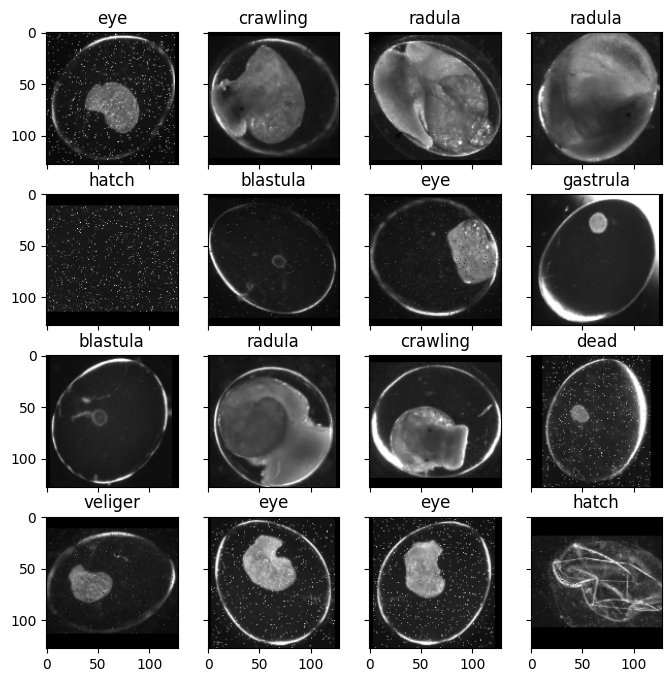

2023-07-13 11:22:16.117038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-07-13 11:22:16.158919: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-07-13 11:22:16.158939: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-07-13 11:22:16.158964: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


73/73 [==============================] - 2s 24ms/step - loss: 0.2520 - accuracy: 0.9101


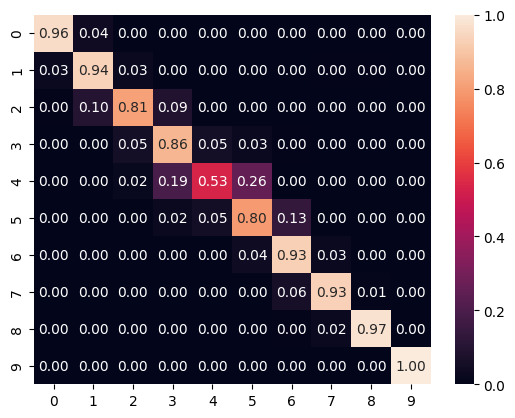

73/73 [==============================] - 2s 24ms/step - loss: 0.2619 - accuracy: 0.8994


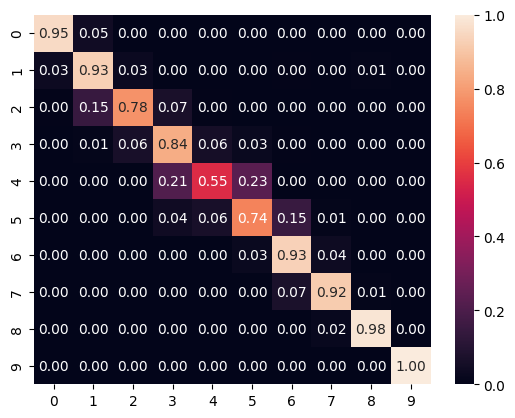

73/73 [==============================] - 2s 25ms/step - loss: 0.2652 - accuracy: 0.9011


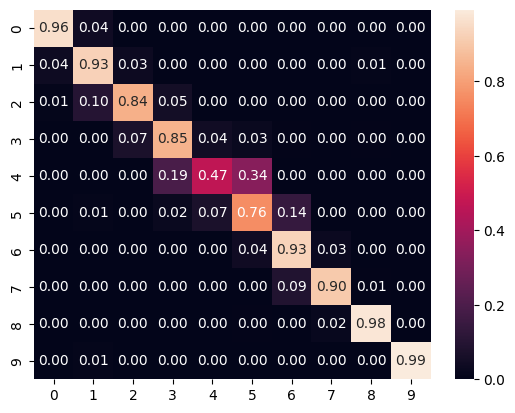

In [3]:
# Train and evaluate with three different seeds for computing metrics
for i in range(3):
    np.random.seed(i)
    python_random.seed(i)
    tf.random.set_seed(i)
    
    model = lstm_cnn3d(input_shape, n_classes=len(events))
    # model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.000001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    class EvaluateCallback(keras.callbacks.Callback):
        def __init__(self):
            super().__init__()
            self.loss = []
            self.accuracy = []

        def on_epoch_end(self, epoch, log=None):
            loss, acc = self.model.evaluate(test_data, verbose=0)
            print('-', 'test_loss:', round(loss, 4), 'test_accuracy:', round(acc, 4))
            self.loss.append(loss)
            self.accuracy.append(acc)

    evaluate_callback = EvaluateCallback()
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=f'{model_save_dir}/categorical_3d_first_frame_ResNet18_epochs_{epochs}_original_staticLR_{i}.h5',
            save_best_only=True,
            monitor='val_accuracy',
            save_weights_only=True
        ),
        evaluate_callback
    ]

    start = time.time()
    history = model.fit(
        train_data,
        epochs=epochs, 
        callbacks=callbacks,
        validation_data=val_data)        
    end = time.time()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(evaluate_callback.loss)
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(evaluate_callback.accuracy)
    plt.show()

    model.load_weights(f'{model_save_dir}/categorical_3d_first_frame_ResNet18_epochs_{epochs}_original_staticLR_{i}.h5')
    test_loss, test_accuracy = model.evaluate(test_data)

    counter = 0
    for batch in test_data:
        ims, labels = batch
        preds = model.predict_on_batch(ims)

        preds = tf.argmax(preds, 1)
        at_cfm = tf.math.confusion_matrix(labels, preds, num_classes=len(events))

        if counter == 0:
            cfm = at_cfm
        else:
            cfm += at_cfm

        counter += 1

    cfm = cfm.numpy()
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cfm, annot=True, fmt='.2f')
    plt.show()

    np.save('./cfm_3d_categorical.npy', cfm)
    
    del model
    keras.backend.clear_session()